# **Welcome to the World of Pacman again!! But this time in a python gym environment** (https://www.gymlibrary.ml/)

---



In [4]:
import gym
from colabgymrender.recorder import Recorder
import matplotlib.pyplot as plt
import numpy
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

class ReplayBuffer(object):
    ''' TO LOAD DATA BATCH'''
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, buffer):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = buffer
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



C:\Users\roman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\colabgymrender\recorder.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Video, display


In [35]:
"""
Some used links:
  https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939
  https://machinelearningknowledge.ai/pytorch-conv2d-explained-with-examples/
  https://datascience.stackexchange.com/questions/64278/what-is-a-channel-in-a-cnn
  https://arxiv.org/pdf/1603.07285v2.pdf
  
A DQN can be built with CNN, which will consist in our case of 4 layers: 
 1) Convolutional(Conv2d) x2
 2) Pooling(MaxPool2d) 
 3) Fully connected(Linear)
 
CNN1:
in_channel = 1, because the input frames after preprocessing are stored in uint8 format.
kernel size is 8 because it is enough to capture a single grid entry(size ~5 pixel) and a little bit of area around it. Choosing a value larger than 5 would also decrease the size of output feature map.
stride is chosen to be 4 because it allows the 50% overlapping of kernels when convolution is conducted, which could theoretically improve feature detection.

pool:
basically exist to reduce the size of input and the amount of calculations.

CNN2:
parameters are adjusted to fit the output from previous layer.

The ReLU activation function is used because it is simple and pretty common.
"""

class DQN(nn.Module):
  def __init__(self, device, actions = 9, height=105, width=80, frames = 1):
    super(DQN, self).__init__()
    self.a = actions
    self.h = height
    self.w = width
    self.device = device
    
    self.cnn_1=nn.Conv2d(in_channels=frames,out_channels=16,kernel_size=8,stride=4) 
    self.pool=nn.MaxPool2d((3,2))
    self.cnn_2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=4)
    self.flat=nn.Flatten()
    self.fc=nn.Linear(64,self.a)

    
  def forward(self,x):
    x=torch.Tensor(x)      # convert the numpy frame to tensor
    x = x.to(self.device)  # perform the device conversion
    x= F.relu(self.cnn_1(x))
    x= self.pool(x)
    x= F.relu(self.cnn_2(x))
    x= self.flat(x)
    actions=self.fc(x)     

    return actions         # the output tensor, which will hold the q values

In [ ]:
#To get preprocessed image:
'''
env=gym.make('MsPacmanDeterministic-v4')
img=env.reset()
ds = img[::2,::2]
grayscale = np.mean(ds, axis=-1).astype(np.uint8)
im = np.expand_dims(grayscale, axis=0)
#im.shape
net=DQN()
net.forward(im)

import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(device,9,105, 80)
target_net = DQN(9,105, 80)
target_net.load_state_dict(policy_net.state_dict())
#optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#sss=DQN(9, 105, 80).to(device)
print(target_net.shape)
#target_net.load_state_dict(policy_net.state_dict())
env=gym.make('MsPacmanDeterministic-v4')
img=env.reset()
ds = img[::2,::2]
grayscale = np.mean(ds, axis=-1).astype(np.uint8)
im = np.expand_dims(grayscale, axis=0)
policy_net(im)'''

In [68]:
class Pacman:
    """
        :param gamma: reward discount
        :param batch_size: replay buffer batch sizes
        :param env: gym environment
        :param num_frames: number of frames per state (and number per action)
    """
    def __init__(self, gamma=.95, batch_size=64,
                env='MsPacmanDeterministic-v4', num_frames=4):

        self.num_frames = num_frames
        self.memory = ReplayBuffer(50000)
        self.gamma = gamma
        self.batch_size = batch_size
        self.score_history = []
        self.env = gym.make(env)
        self.start = self.get_init_frame()
        self.num_actions = self.env.action_space.n
        _, height, width = len(self.start[0]),len(self.start[1]),len(self.start[2])
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.policy = DQN(self.device, self.num_actions, height, width, 1).to(self.device)
        self.target = DQN(self.device, self.num_actions, height, width, 1).to(self.device)
        self.target.load_state_dict(self.policy.state_dict())
        
        # For loss use the mean squared error
        self.loss = nn.MSELoss()
        
        #According to the project description: "we need to use a gradient descent based optimization method",
        #so we will use the Adam, which is a stochastic gradient descent method
        #learning rate is 0.001 because it is the most common value in different online sources
        self.opt = torch.optim.Adam(self.policy.parameters(), lr=0.001) 
        self.eps = 0.95
        self.eps_amplifier = 10000
        
        self.steps = 0 # used for exploitaition/exploration
        
    def get_init_frame(self):
        self.lives = 3
        frame = self.preprocess(self.env.reset())
        frames = []
        for i in range(self.num_frames):
            frames.append(frame)
        return np.array(frames)

    def preprocess(self, img):
        ds = img[::2,::2]
        grayscale = np.mean(ds, axis=-1).astype(np.uint8)
        return np.expand_dims(grayscale, axis=0)

    def fit_model(self, sample):

        policy = self.policy
        target = self.target
        dev = self.device
        loss=0.0

        states, actions, next_states, rewards, non_terms = zip(*sample)
        policy_Q_values = []   # Q-values predicted by policy
        expected_Q_values = [] # defined as target Q-values in project description 
        
        for b in range(0, self.batch_size):
            # 'states' has the following shape: 64x1x4x1x105, so we either have to transform it to the batch(e.g. extracting single frames into a list) or apply policy step-wise.
            # Step-wise method was chosen because it is seems easier and no significant improvement was seen with the batch method.
            out = policy(states[b][0]) 
            Max = 0
            for c in range(0, len(out)):
                Max = max(Max, out[c][actions[b]]) # Choose the q-value of the corresponding action
            policy_Q_values.append(Max)
            expected_Q_values.append(rewards[b] + self.gamma*torch.max(target(states[b][0]))*non_terms[b]) # calculate the target Q-value

        '''----------------------'''
        # link used for this part: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
        
        loss = self.loss(torch.Tensor(policy_Q_values), torch.Tensor(expected_Q_values))
        self.opt.zero_grad()
        self.opt.step()

        target.load_state_dict(policy.state_dict())
        '''----------------------'''
        
        return loss


    def choose_best_action(self, frames):
 
        # Epsilon(second parameter in 'np.random.binomial' below) will be adjusted in each step.
        # A CNN is is not able to predict actions in the beginning, so at first actions will be chosen mostly randomly.
        # After some specified 'eps_amplifier' value will be equal to 'steps' the epsilon becomes constant = self.eps, 
        # so mostly the network will predict actions and only seldom will they be chosen randomly.

        if self.steps > self.eps_amplifier:
            threshold = self.eps_amplifier
        else:
            threshold = self.steps
            self.steps += 1
             
        # Bernoulli distribution is used to select either exploitation(p = self.eps) or exploration(p = 1-self.eps)
        # A tensor is 'compressed' to 1 dimension and after that the greatest index is chosen, that will be a predicted action
        if np.random.binomial(1,self.eps * threshold / self.eps_amplifier):
            return torch.argmax(self.policy(frames), dim=1).max().item()
        else:
            return self.env.action_space.sample() 

    def q_iteration(self, frames, iteration):
        
        env = self.env
        action = self.choose_best_action(frames)
        
        is_done = False
        new_frames = []
        total_reward = 0
        total_score = 0
        # Play one game iteration:
        for i in range(self.num_frames):
            if not is_done:
                new_frame, reward, is_done, lives = self.env.step(action)
                lives = lives['lives']
                new_frame = self.preprocess(new_frame)
                total_score += reward
                if lives < self.lives:
                    self.lives = lives
                total_reward += reward
            else:
                reward = 0
            new_frames.append(new_frame)

        non_term = 1
        if is_done:
            non_term = 0

        mem = (np.expand_dims(np.array(frames), axis=0), action,
               np.expand_dims(np.array(new_frames), axis=0), total_reward, non_term)
        self.memory.push(mem)

        loss = None
        # Sample and fit
        if iteration > 64:
            batch = self.memory.sample(self.batch_size)
            loss= self.fit_model(batch)

        return is_done, total_reward, new_frames, loss

    def train(self, epochs=10000, start_iter=0, updates=500):
        self.epochs = epochs
        self.score_history = []
        self.loss_hist = []
        self.updates = updates
        self.its_hist = []
        iteration = start_iter
        running_loss = 0
        running_count = 0
        running_score = 0
        running_its = 0
        for e in range(epochs):
            is_done = False
            e_reward = 0
            e_its = 0
            frames = self.get_init_frame()

            while not is_done:
                is_done, reward, frames, loss = self.q_iteration(frames, iteration)
                iteration += 1
                e_reward += reward
                e_its += 1
                if loss is not None:
                    running_loss += loss
                    running_count += 1
            running_score += e_reward
            running_its += e_its
            if e%10 == 0:
                era_score = running_score / 10
                era_its = running_its / 10
                self.score_history.append(era_score)
                self.loss_hist.append(running_loss / running_count)
                self.its_hist.append(era_its)
                print(f'---> Epoch {e}/{epochs}, Score: {era_score}')
                print(f'-------->Loss: {running_loss / running_count}, Its: {era_its}')
                running_loss = 0
                running_count = 0
                running_score = 0
                running_its = 0

In [ ]:
# import seaborn as sns
pacman = Pacman()
pacman.train(50)

0
---> Epoch 0/50, Score: 46.0
-------->Loss: 129.32777404785156, Its: 13.6
1
2
3


[43.0, 411.0, 566.0, 595.0, 488.0]


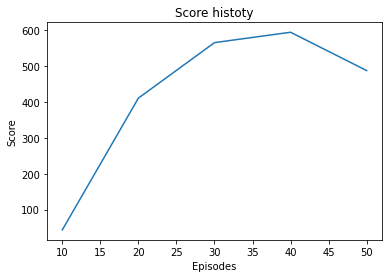

In [64]:
# Unfortunately the training could not be conducted properly, 
# because the GPU was not available on own devices and the Collab has thrown some errors(e.g. Environment MsPacmanDeterministic doesn't exist), which could not be solved.
# So there is no information about convergence.

def plot_score(pacman):
    print(pacman.score_history)
    plt.plot(range(10, pacman.epochs+1, 10), pacman.score_history)
    plt.xlabel('Episodes')
    plt.ylabel('Score')
    plt.title('Score histoty')
    return 

plot_score(pacman)

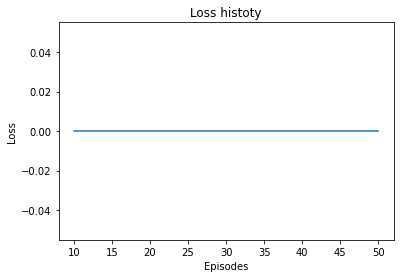

In [65]:
def plot_loss(pacman):
    plt.plot(range(10, pacman.epochs+1, 10), pacman.loss_hist)
    plt.xlabel('Episodes')
    plt.ylabel('Loss')
    plt.title('Loss histoty')
    return

plot_loss(pacman)

In [9]:
pacman.env = Recorder(pacman.env, "./video")

state = pacman.get_init_frame()
is_done = False
while not is_done:
    action = pacman.choose_best_action(state)
    new_state = []
    for i in range(20):
        new_frame, reward, is_done, lives = pacman.env.step(action)
        if is_done:
            break

In [10]:
pacman.env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [25]:
print(pacman.getsteps())

1001


In [48]:
x=range(0,101,10)
for i in x:
    print(i)

0
10
20
30
40
50
60
70
80
90
100
